# 2. Preprocessing
## 2.04 Reshape datasets for training




In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

## Loading the data
A sample dataset is contained in the git repository.

We use `xarray` to access the files, as it provides us with a very powerful interface to work with the data. Let's open the files and see what's in there:

In [2]:
era5 = xr.open_dataset('../../data/smallsampledata-era5.nc')
glofas = xr.open_dataset('../../data/smallsampledata-glofas.nc')

Its datatype is `xarray.Dataset`, containing a spatio-temporal subset of 5 variables that we selected from the original ERA5 dataset. It also contains one derived variable (`rtp_500-850`) that is used in Meteorology quite a bit because it is proportional to mass-weighted mean temperature of the air, in this case between 850 and 500 hPa. It could be an additional predictor to classify the weather regime.

### Selecting the predictand
The target variable shall be the discharge at the point where the Danube river leaves the data domain. This is given by the point within the catchment where the discharge is the highest, so we first filter by the catchment basin shapefile (Worldbank dataset "Global River Basins")

To select the basin from the shapefile, we use a function defined in `./aux/utils.py`. The interested user may have a look there how it is done, but it would obstruct the clarity in this notebook. To import the function it needs to be present in the current processes path. We do that by adding the parent/main directory to `sys.path`. In this way we can import some function in `./aux/utils_flowmodel.py` by `from aux.utils_flowmodel import somefunction`.

In [3]:
import sys
sys.path.append("../../")
from python.aux.utils_floodmodel import get_mask_of_basin, add_shifted_variables

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


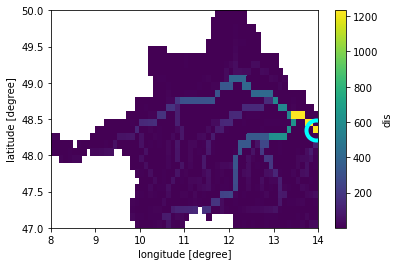

In [4]:
dis_mean = glofas['dis'].mean('time')
danube_catchment = get_mask_of_basin(dis_mean)
dis = glofas['dis'].where(danube_catchment)

maximum = dis.where(dis==dis.max(), drop=True)
lat, lon = float(maximum.latitude), float(maximum.longitude)

dis.mean('time').plot()
plt.gca().plot(lon, lat, color='cyan', marker='o', 
               markersize=20, mew=4, markerfacecolor='none')

### Feature engineering: Spatial aggregation 
Repeated from **(from Notebook 2.03)**

In [5]:
bins = [0, 0.8, 2.4, 10.25, 10000]

dis_mean = dis.mean('time')
cluster = dict()
for i in range(len(bins)-1):
    cluster[str(i)] = (dis_mean >= bins[i]) & (dis_mean < bins[i+1])
    cluster[str(i)].attrs['units'] = None
    
cluster = xr.Dataset(cluster, coords=dict(clusterId=('clusterId', range(len(bins))),
                                          latitude=('latitude', dis_mean.latitude),
                                          longitude=('longitude', dis_mean.longitude)))
cluster = cluster.to_array('clusterId')

In [6]:
from python.aux.utils_floodmodel import shift_and_aggregate, aggregate_clustersum

Add shifted variables.

In [18]:
shifts = [1, 2, 3]
shift_vars = ['lsp', 'cp']

Xs = add_shifted_variables(era5, shifts, variables=shift_vars)

In [19]:
Xs['lsp-4-10'] = shift_and_aggregate(Xs['lsp'], shift=4, aggregate=7)
Xs['lsp-11-24'] = shift_and_aggregate(Xs['lsp'], shift=14, aggregate=14)
Xs['lsp-25-54'] = shift_and_aggregate(Xs['lsp'], shift=28, aggregate=30)
Xs['lsp-55-180'] = shift_and_aggregate(Xs['lsp'], shift=55, aggregate=126)

Add change of snow depth as feature.

In [29]:
sd_diff = Xs['sd'].diff(dim='time')
Xs = Xs.assign({'sd_diff': sd_diff})

Remove unimportant features.

In [31]:
ignore_features = ['tcwv', 'rtp_500-850']
Xs = Xs.drop(ignore_features)

In [34]:
X = Xs.interp(latitude=glofas.latitude, longitude=glofas.longitude)

Here, we added the option to either use clustering for spatial aggregation, or means over the whole catchment.

In [36]:
cluster_switch = False
if cluster_switch:
    Xagg = aggregate_clustersum(X, cluster, 'clusterId')
else:
    X_catchment = X.where(danube_catchment, drop=True)
    Xagg = X_catchment.mean(['latitude', 'longitude'])
Xagg.data_vars

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Data variables:
    cp          (time) float64 0.002797 0.001074 ... 2.064e-05 2.792e-05
    lsp         (time) float64 0.003084 0.01113 0.01319 ... 0.000322 0.0009015
    swvl1       (time) float64 0.3698 0.3697 0.4002 ... 0.3741 0.371 0.3686
    ro          (time) float64 4.071e-05 4.08e-05 ... 4.307e-05 4.372e-05
    sd          (time) float64 0.05089 0.06464 0.06186 ... 0.03501 0.03384
    lsp-1       (time) float64 nan 0.003084 0.01113 ... 8.925e-05 0.000322
    lsp-2       (time) float64 nan nan 0.003084 ... 0.002427 7.934e-05 8.925e-05
    lsp-3       (time) float64 nan nan nan ... 0.007294 0.002427 7.934e-05
    lsp-4-10    (time) float64 nan nan nan nan ... 0.005709 0.006588 0.005324
    lsp-11-24   (time) float64 nan nan nan nan ... 0.001202 0.001108 0.0009275
    lsp-25-54   (time) float64 nan nan nan nan ... 0.002305 0.002124 0.001885
    lsp-55-180  (time) float64 nan nan nan nan ... 0.001596 0.001616 0.001616
    cp-1        (time) float64 nan 0.002797 0.001074 ... 2.027e

In [37]:
y = glofas['dis'].interp(latitude=lat, longitude=lon)
y

<xarray.DataArray 'dis' (time: 5478)>
array([798.361572, 792.207703, 796.706116, ..., 783.30896 , 782.144958,
       778.828003])
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
    latitude   float64 48.35
    longitude  float64 13.95
Attributes:
    long_name:  discharge
    units:      m3/s

Save the preprocessed features as well as the predictand into the data folder.

In [39]:
Xagg = Xagg.assign({'dis': y})

In [42]:
Xagg.to_netcdf('../../data/features_xy.nc')

## The reshaping procedure

The reshaping procedure is not complex. What is our goal?

### The plain-vanilla neural net (for core keras layers)
In the end we want to have the predictor matrix `X` and the predictand vector `y` as `xr.DataArray` with dimensions: `(samples, features)` and `(samples,)` respectively.


#### Process
1. **Convert to arrays**
to be enable all following matrix-operations.
2. **Stack the feature-dimensions of your array**
i.e. if you want every gridpoint of your dataset as separate predictor variable, then `.stack(features=['latitude', 'longitude'])`. `features` will be the name of the dimension containing both old dimensions. The output should be 2-dimensional (samples, features).
3. **Drop any features that are NaN**
may be needed if you applied `.where()` to the array, which sets the False condition to NaN.

4. **Drop remaining spatial coordinates**
may be needed in some cases.

5. **Drop NaN rows in both X and y**
Rename the features dimension temporarily, concat X with y, drop samples containing any NaN and separate both X and y again. Rename features back again.


In [22]:
def reshape_scalar_predictand(X_dis, y):
    """Reshape, merge predictor/predictand in time, drop nans.
    
    Parameters
    ----------
        X_dis : xr.Dataset
            variables: time shifted predictors (name irrelevant)
            coords: time, latitude, longitude
        y : xr.DataArray
            coords: time
    """
    if isinstance(X_dis, xr.Dataset):
        X_dis = X_dis.to_array(dim='var_dimension')

    # stack -> seen as one dimension for the model
    stack_dims = [a for a in X_dis.dims if a != 'time']  # all except time
    X_dis = X_dis.stack(features=stack_dims)
    Xar = X_dis.dropna('features', how='all')  # drop features that only contain NaN

    # to be sure that these dims are not in the output
    for coord in ['latitude', 'longitude']:
        if coord in y.coords:
            y = y.drop(coord)

    # merge times
    y.coords['features'] = 'predictand'
    Xy = xr.concat([Xar, y], dim='features')  # maybe merge instead concat?
    Xyt = Xy.dropna('time', how='any')  # drop rows with nan values

    Xda = Xyt[:, :-1]  # last column is predictand
    yda = Xyt[:, -1].drop('features')  # features was only needed in merge
    return Xda, yda

This function is available from here:

`from python.aux.utils_floodmodel import reshape_scalar_predictand`


In [23]:
Xda, yda = reshape_scalar_predictand(Xagg, y)

In [25]:
Xda.shape, yda.shape

((5134, 52), (5134,))

This concludes the part for the core keras layers, as we have the `X` and `y` arrays needed to fit the model to the data.



### The recurrent neural net (for recurrent keras layers)
For a recurrent neural net architecture like RNN or LSTM we need `X` and `y` as arrays of dimensions `(samples, times, features)` and `(samples, times)`.


The reshaping procedure is not that different but it involves a feature array `X` of a different shape (as described above), such that we have to introduce minor changes.
You could probably also merge both reshaping procedures.

In [ ]:
def reshape_multiday_predictand(X_dis, y):
    """Reshape, merge predictor/predictand in time, drop nans.
    
    Parameters
    ----------
        X_dis : xr.Dataset
            variables: time shifted predictors (name irrelevant)
            coords: time, latitude, longitude
        y : xr.DataArray (multiple variables, multiple timesteps)
            coords: time, forecast_day
    """
    if isinstance(X_dis, xr.Dataset):
        X_dis = X_dis.to_array(dim='var_dimension')

    # stack -> seen as one dimension for the model
    stack_dims = [a for a in X_dis.dims if a != 'time']  # all except time
    X_dis = X_dis.stack(features=stack_dims)
    Xar = X_dis.dropna('features', how='all')  # drop features that only contain NaN

    if not isinstance(y, xr.DataArray):
        raise TypeError('Supply `y` as xr.DataArray.'
                        'with coords (time, forecast_day)!')

    # to be sure that these dims are not in the output
    for coord in ['latitude', 'longitude']:
        if coord in y.coords:
            y = y.drop(coord)

    out_dim = len(y.forecast_day)
    y = y.rename(dict(forecast_day='features'))  # rename temporarily
    Xy = xr.concat([Xar, y], dim='features')  # maybe merge instead concat?
    Xyt = Xy.dropna('time', how='any')  # drop rows with nan values

    Xda = Xyt[:, :-out_dim]  # last column is predictand
    yda = Xyt[:, -out_dim:]  # features was only needed in merge
    yda = yda.rename(dict(features='forecast_day'))  # change renaming back to original
    return Xda, yda
